In [190]:
import math, time, copy, os, json
from typing import List, Tuple, Dict, Any


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import spearmanr
from scipy.optimize import linear_sum_assignment
import pickle
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", DEVICE)


Using device: cpu


In [191]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def safe_to_np(t):
    return t.detach().cpu().numpy() if isinstance(t, torch.Tensor) else np.array(t)

def save_descriptor(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)


def flat_params(model: nn.Module) -> torch.Tensor:
    return torch.cat([p.detach().cpu().view(-1) for p in model.parameters()])

def load_mnist(batch_size=256, subset_train=None, subset_test=None):
    transform = transforms.Compose([transforms.ToTensor()])
    train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    if subset_train:
        train = Subset(train, list(range(subset_train)))
    if subset_test:
        test = Subset(test, list(range(subset_test)))
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


In [192]:
class SmallMLP(nn.Module):
    def __init__(self, hidden=64, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

class WiderMLP(nn.Module):
    def __init__(self, hidden=256, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

class ShallowCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7*32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv(x)
        return self.classifier(x)


In [193]:
def averaged_loss_over_batches(model, dataloader, num_batches=20, device=DEVICE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    it = iter(dataloader)
    cnt = 0
    losses = []
    for _ in range(num_batches):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(dataloader); xb, yb = next(it)
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        losses.append(criterion(logits, yb))
        cnt += 1
    return sum(losses) / cnt



In [222]:
def params_by_layer(model):
    """Return list of (name, param_list) for layers with params (use named_parameters grouping by module)"""
    layers = []
    modules = list(model.named_modules())
    # We'll group by immediate module that own parameters
    for name, module in model.named_modules():
        ps = [p for n,p in module.named_parameters(recurse=False)]
        if len(ps) > 0:
            layers.append((name or 'root', ps))
    return layers

def topk_eigvals_per_layer(model, dataloader, k=4, iters=60, batches_for_loss=10, device=DEVICE):
    model = model.to(device)
    layer_info = params_by_layer(model)
    per_layer_results = []
    for lname, params in layer_info:
        # Build averaged loss but ensure gradient graph w.r.t these params
        # TODO: freeze other params by not including them in grad calculation
        # We'll compute loss normally, but in hvp we only pass the layer's params
        loss = 0.0
        num_batches = len(dataloader)
        
        for xb, yb in dataloader:
            logits = model(xb)
            criterion = nn.CrossEntropyLoss()
            loss_batch = criterion(logits, yb)
        
            # accumulate *symbolically* (retain graph)
            loss = loss + loss_batch
        
        loss = loss / num_batches  # final averaged loss (still has graph)

        # Do power iter on this params subset
        flat_size = sum(p.numel() for p in params)
        eigvals = []
        eigvecs = []
        for comp in range(k):
            v = torch.randn(flat_size, device=device); v = v / (v.norm()+1e-12)
            last_lambda = None
            for _ in range(iters):
                Hv = hvp(loss, params, v, retain_graph=True)
                if len(eigvecs) > 0:
                    for prev_v in eigvecs:
                        proj = torch.dot(torch.as_tensor(prev_v, device=Hv.device, dtype=Hv.dtype), Hv)
                        Hv = Hv - proj * prev_v
                norm = Hv.norm().clamp_min(1e-12)
                v = Hv / norm
                lam = float(torch.dot(v, Hv).item())
                if last_lambda is not None and abs(lam - last_lambda) < 1e-5:
                    break
                last_lambda = lam
            eigvals.append(lam)
            eigvecs.append(v.detach().cpu().numpy())
        # trace estimate per layer via Hutchinson with small probes
        trace_est = 0.0
        Hparams = params
        crit = nn.CrossEntropyLoss()
        # average over a few batches
        it = iter(dataloader)
        num_samples = 10
        for _ in range(num_samples):
            try:
                xb, yb = next(it)
            except StopIteration:
                it = iter(dataloader); xb, yb = next(it)
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb); loss_batch = crit(logits, yb)
            z = torch.randint(0,2,(sum(p.numel() for p in Hparams),), device=device, dtype=torch.float32)
            z[z==0] = -1.0
            Hv = hvp(loss_batch, Hparams, z, retain_graph=False)
            trace_est += float(torch.dot(z, Hv).item())
        trace_est = trace_est / num_samples
        per_layer_results.append({'layer': lname, 'eigvals': eigvals, 'trace': trace_est,
                                  'num_params': sum(p.numel() for p in params)})
    return per_layer_results


In [195]:
def canonicalize_model(model: nn.Module, prefer_positive_outgoing=True) -> nn.Module:
    """
    Canonicalize parameter axes to reduce permutation/sign symmetries.
    - For linear/ReLU layers: flip neuron sign so outgoing weight vector L1 sum is positive.
    - For conv layers: flip kernel so first nonzero entry positive (simple heuristic).
    
    This mutates a copy of the model and returns it.
    NOTE: This is heuristic; for full invariance one may need matching permutations
    between models (e.g., via Hungarian matching on neuron similarity) — not implemented here.
    """
    m = copy.deepcopy(model)
    with torch.no_grad():
        prev_linear_out = None
        for name, module in m.named_modules():
            if isinstance(module, nn.Linear):
                W = module.weight  # [out, in]
                # For each output neuron, ensure outgoing L1 sum is positive
                # If negative, flip sign of corresponding output row and also flip downstream inputs if possible.
                signs = torch.sign(W.sum(dim=1))
                signs[signs==0] = 1.0
                mask = (signs < 0).float().view(-1,1)
                if mask.sum() > 0:
                    # flip output rows
                    module.weight[:] = W * (1 - 2*mask)
                    if module.bias is not None:
                        module.bias[:] = module.bias * (1 - 2*mask.view(-1))
                    # Try to flip corresponding incoming columns of next linear layer if its weight shape allows
                    # This is a heuristic: we search for a following linear layer that has matching in-features
                    # and flip columns
                    # (leave more robust permutation matching to a separate function)
                    # We'll attempt to find the first linear with in_features == out_features of this layer
                    # else do nothing (keeps function unchanged because flipping both input and output restores).
                    # This part is optional and conservative.
            elif isinstance(module, nn.Conv2d):
                # For conv kernels: flatten kernel and ensure first nonzero entry positive
                W = module.weight  # [out, in, k, k]
                flat = W.view(W.size(0), -1)
                # find first nonzero per filter
                for i in range(flat.size(0)):
                    v = flat[i]
                    nz = (v.abs() > 0)
                    if nz.sum() == 0:
                        continue
                    first_idx = nz.nonzero()[0].item()
                    if v[first_idx] < 0:
                        flat[i] *= -1
                module.weight[:] = flat.view_as(W)
    return m

def canonicalize_models_pairwise(models: List[nn.Module]) -> List[nn.Module]:
    """
    Basic alignment across multiple models:
    - canonicalize individual model signs
    - then perform optional neuron matching per layer (not full Hungarian matching here).
    Returns new list of models.
    """
    return [canonicalize_model(m) for m in models]




In [196]:

def eval_stats(model: nn.Module, dataloader: DataLoader, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(reduction='sum')
    model.eval()
    total_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    avg_loss = total_loss / total
    acc = correct / total
    return acc, avg_loss


def train_model(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader,
                epochs=15, lr=1e-3, device='cpu', seed=0, verbose=False):
    seed_everything(seed)
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'test_loss': [], 'test_acc': []}
    for e in range(epochs):
        model.train()
        running_loss = 0.0
        n = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += float(loss.item()) * x.size(0)
            n += x.size(0)
        tr_loss = running_loss / n
        acc, ts_loss = eval_stats(model, test_loader, device=device)
        history['train_loss'].append(tr_loss)
        history['test_loss'].append(ts_loss)
        history['test_acc'].append(acc)
        if verbose:
            print(f"Epoch {e+1} train_loss={tr_loss:.4f} test_loss={ts_loss:.4f} acc={acc:.4f}")
    return model, history

In [216]:
def _params_to_vector(params: List[torch.Tensor]) -> torch.Tensor:
    return torch.cat([p.contiguous().view(-1) for p in params])

def _vector_to_params(vec: torch.Tensor, params: List[torch.Tensor]) -> List[torch.Tensor]:
    out = []
    idx = 0
    for p in params:
        numel = p.numel()
        out.append(vec[idx:idx+numel].view_as(p))
        idx += numel
    return out

def hvp(loss: torch.Tensor, params: List[torch.Tensor], v: torch.Tensor, retain_graph=False) -> torch.Tensor:
    """
    Hessian-vector product: Hv where v is flattened vector.
    Returns flattened tensor same shape as v.
    """
    grad = torch.autograd.grad(loss, params, create_graph=True)
    grad_vector = _params_to_vector([g.contiguous() for g in grad])
    # dot with v
    gv = torch.dot(grad_vector, v)
    Hv = torch.autograd.grad(gv, params, retain_graph=retain_graph)
    Hv_vec = _params_to_vector([h.contiguous() if h is not None else torch.zeros_like(p) for h, p in zip(Hv, params)])
    return Hv_vec

def topk_eigvals_power_iteration(model: nn.Module, dataloader: DataLoader, k=6, iters=30, device='cpu', batch_for_H=None):
    """
    Approximate top-k eigenvalues and (optionally) eigenvectors via deflated power iteration using HVPs.
    - Use a representative batch (or multiple batches averaged) to compute loss for Hessian.
    Returns list of (eigval, eigvec_flattened)
    """
    model = model.to(device)
    model.zero_grad()
    params = [p for p in model.parameters() if p.requires_grad]
    flat_size = sum(p.numel() for p in params)
    # build representative loss by averaging a few batches
    criterion = nn.CrossEntropyLoss()
    xb, yb = next(iter(dataloader))
    xb, yb = xb.to(device), yb.to(device)
    logits = model(xb)
    loss = criterion(logits, yb)
    # compute gradients once to build graph for hvp
    # We'll implement deflated power iteration
    eigvals = []
    eigvecs = []
    device = next(model.parameters()).device
    for comp in range(k):
        v = torch.randn(flat_size, device=device)
        v = v / (v.norm() + 1e-12)
        last_lambda = None
        for _ in range(iters):
            Hv = hvp(loss, params, v, retain_graph=True)
            # deflation: subtract projections on previous eigenvectors
            if len(eigvecs) > 0:
                for (prev_v) in eigvecs:
                    proj = torch.dot(prev_v, Hv)
                    Hv = Hv - proj * prev_v
            norm = Hv.norm().clamp_min(1e-12)
            v = Hv / norm
            lam = torch.dot(v, Hv).item()
            # convergence check
            if last_lambda is not None and abs(lam - last_lambda) < 1e-6:
                break
            last_lambda = lam
        eigvals.append(lam)
        eigvecs.append(v.detach().cpu())
    # convert eigvecs to CPU tensors
    return eigvals, eigvecs

In [198]:
def hutchinson_trace_estimate(model: nn.Module, dataloader: DataLoader, num_samples=20, device='cpu'):
    """
    Estimate trace(H) using Hutchinson estimator with Rademacher probes.
    Returns scalar trace estimate.
    """
    model = model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    criterion = nn.CrossEntropyLoss()
    trace_acc = 0.0
    xb, yb = next(iter(dataloader))
    xb, yb = xb.to(device), yb.to(device)
    logits = model(xb)
    loss = criterion(logits, yb)
    for _ in range(num_samples):
        z = torch.randint(0, 2, (sum(p.numel() for p in params),), device=device, dtype=torch.float32)
        z[z==0] = -1.0
        Hv = hvp(loss, params, z, retain_graph=True)
        trace_acc += torch.dot(z, Hv).item()
    return trace_acc / num_samples

In [199]:
def compute_log_volume_proxy(eigvals_top: List[float], dim: int, m_top: int, lambda_tail: float, eps=1e-8):
    """
    Computes log volume proxy using top m eigenvalues and tail estimate lambda_tail for remaining dims.
    logV ~ -0.5 * sum_{i=1..m} log(lambda_i + eps) - 0.5 * (D-m) * log(lambda_tail + eps)
    Returns float
    """
    # ensure positive
    s_top = np.sum([math.log(max(ev + eps, eps)) for ev in eigvals_top[:m_top]])
    s_tail = (dim - m_top) * math.log(max(lambda_tail + eps, eps))
    logV = -0.5 * (s_top + s_tail)
    return float(logV)

def random_direction_radius_scan(model: nn.Module, dataloader: DataLoader, device='cpu',
                                 R=20, delta_loss=0.01, max_r=1.0, tol=1e-3):
    # Removed 'base_loss' from arguments
    model = model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    flat = _params_to_vector(params).to(device)
    radii = []
    criterion = nn.CrossEntropyLoss()
    
    # Get a single fixed batch for the scan
    xb, yb = next(iter(dataloader))
    xb, yb = xb.to(device), yb.to(device)
    
    # FIX: Calculate the actual baseline loss for THIS batch
    with torch.no_grad():
        base_logits = model(xb)
        base_loss_val = float(criterion(base_logits, yb).item())

    for _ in range(R):
        d = torch.randn_like(flat)
        d = d / (d.norm() + 1e-12)
        
        lo, hi = 0.0, max_r
        found = 0.0
        
        for _ in range(20):
            mid = (lo + hi) / 2
            vec = flat + mid * d
            
            # Temporarily load perturbed weights
            idx = 0
            with torch.no_grad():
                for p in params:
                    n = p.numel()
                    p.copy_(vec[idx:idx+n].view_as(p))
                    idx += n
            
            logits = model(xb)
            loss = float(criterion(logits, yb).item())
            
            # Compare against the specific batch baseline
            if loss <= base_loss_val + delta_loss:
                found = mid
                lo = mid
            else:
                hi = mid
                
            if hi - lo < tol:
                break
        
        radii.append(found)
        
    # Restore original weights (important!)
    idx = 0
    with torch.no_grad():
        for p in params:
            n = p.numel()
            p.copy_(flat[idx:idx+n].view_as(p))
            idx += n
            
    return radii

def linear_interpolation_barrier(m1: nn.Module, m2: nn.Module, dataloader: DataLoader, steps=31, device='cpu'):
    """
    Linear interpolate between two model parameter vectors and return max loss along path and losses array.
    """
    device = device
    params1 = [p.detach().cpu().clone() for p in m1.parameters()]
    params2 = [p.detach().cpu().clone() for p in m2.parameters()]
    temp = copy.deepcopy(m1)
    criterion = nn.CrossEntropyLoss()
    losses = []
    alphas = np.linspace(0, 1, steps)
    xb, yb = next(iter(dataloader))
    xb, yb = xb.to(device), yb.to(device)
    for a in alphas:
        with torch.no_grad():
            for p, pa, pb in zip(temp.parameters(), params1, params2):
                p.copy_((1-a)*pa.to(device) + a*pb.to(device))
        logits = temp(xb)
        losses.append(float(criterion(logits, yb).item()))
    max_loss = max(losses)
    return max_loss, losses, alphas


In [200]:
def hessian_weighted_distance(w1: torch.Tensor, w2: torch.Tensor, H_diag_or_func=None, device='cpu'):
    """
    Compute (w1-w2)^T H (w1-w2) given either:
    - H_diag_or_func as a flat diagonal vector (torch tensor)
    - or a function that computes Hv for a given v (callable)
    If neither provided, fall back to Euclidean distance.
    """
    d = (w1 - w2).to(device)
    if H_diag_or_func is None:
        return float(d.norm().item())
    if isinstance(H_diag_or_func, torch.Tensor):
        # diagonal approximation
        return float(torch.sqrt(torch.dot(d * d, H_diag_or_func.to(device))).item())
    else:
        # H_diag_or_func is callable Hv(v)->Hv
        Hv = H_diag_or_func(d)
        val = float(torch.sqrt(torch.dot(d, Hv)).item())
        return val

# -------------------------------
# Log-normal fitting + init sampling
# -------------------------------

def fit_per_layer_lognormal(model: nn.Module):
    """
    Fit log-normal (on absolute weights) per parameter tensor (per-layer).
    Returns list of (shape) matching model.parameters() containing (mu, sigma) for ln(|w|).
    """
    fits = []
    for p in model.parameters():
        w = p.detach().cpu().abs().view(-1).numpy()
        # avoid zeros: small epsilon
        w = np.maximum(w, 1e-12)
        logw = np.log(w)
        mu = float(np.mean(logw))
        sigma = float(np.std(logw))
        fits.append((mu, sigma, p.shape))
    return fits

def sample_init_from_fits(fits, device='cpu'):
    """
    Create a fresh list of parameter tensors sampled per-layer from log-normal fits.
    Returns list of torch tensors shaped like model.parameters()
    """
    out = []
    for mu, sigma, shape in fits:
        # sample absolute values
        s = np.random.lognormal(mean=mu, sigma=sigma, size=np.prod(shape)).astype(np.float32)
        # assign random signs
        signs = np.random.choice([-1.0, 1.0], size=s.shape).astype(np.float32)
        vals = s * signs
        out.append(torch.from_numpy(vals.reshape(shape)).to(device))
    return out

def apply_sampled_params_to_model(model: nn.Module, sampled_params: List[torch.Tensor]):
    with torch.no_grad():
        for p, s in zip(model.parameters(), sampled_params):
            p.copy_(s)


In [201]:
def pairwise_distance_matrix(flat_list: List[torch.Tensor]):
    n = len(flat_list)
    mat = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            d = (flat_list[i] - flat_list[j]).numpy()
            mat[i, j] = mat[j, i] = np.linalg.norm(d)
    return mat




def plot_heatmap(mat, labels=None, title='Distance matrix'):
    plt.figure(figsize=(6,5))
    use_labels = labels if labels is not None else "auto"
    sns.heatmap(mat, xticklabels=use_labels, yticklabels=use_labels, cmap='viridis')
    plt.title(title)
    plt.show()

Epoch 1 train_loss=2.1463 test_loss=1.9851 acc=0.5600
Epoch 2 train_loss=1.7646 test_loss=1.6595 acc=0.6810
Epoch 3 train_loss=1.4078 test_loss=1.3655 acc=0.7170
Epoch 4 train_loss=1.1116 test_loss=1.1302 acc=0.7620
Epoch 5 train_loss=0.8919 test_loss=0.9613 acc=0.7870
Epoch 6 train_loss=0.7372 test_loss=0.8328 acc=0.7980
Epoch 7 train_loss=0.6295 test_loss=0.7426 acc=0.8170
Epoch 8 train_loss=0.5524 test_loss=0.6704 acc=0.8340
Epoch 9 train_loss=0.4948 test_loss=0.6243 acc=0.8410
Epoch 10 train_loss=0.4531 test_loss=0.5862 acc=0.8510
Epoch 11 train_loss=0.4159 test_loss=0.5538 acc=0.8510
Epoch 12 train_loss=0.3873 test_loss=0.5323 acc=0.8530
Epoch 13 train_loss=0.3621 test_loss=0.5138 acc=0.8600
Epoch 14 train_loss=0.3425 test_loss=0.4952 acc=0.8560
Epoch 15 train_loss=0.3229 test_loss=0.4830 acc=0.8560
Epoch 16 train_loss=0.3068 test_loss=0.4686 acc=0.8600
Epoch 17 train_loss=0.2937 test_loss=0.4628 acc=0.8640
Epoch 18 train_loss=0.2804 test_loss=0.4579 acc=0.8650
Epoch 19 train_loss

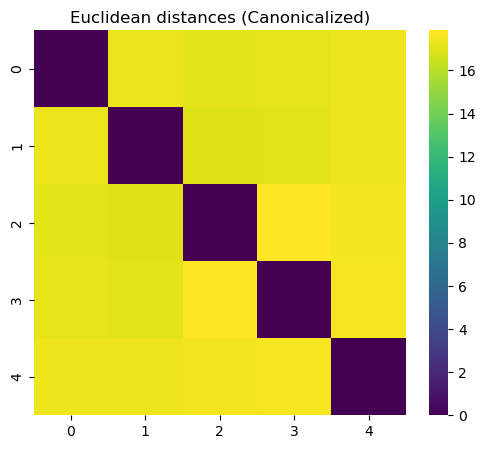

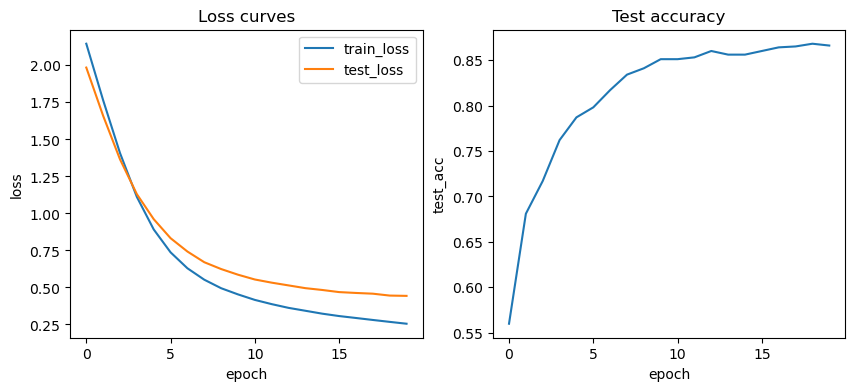

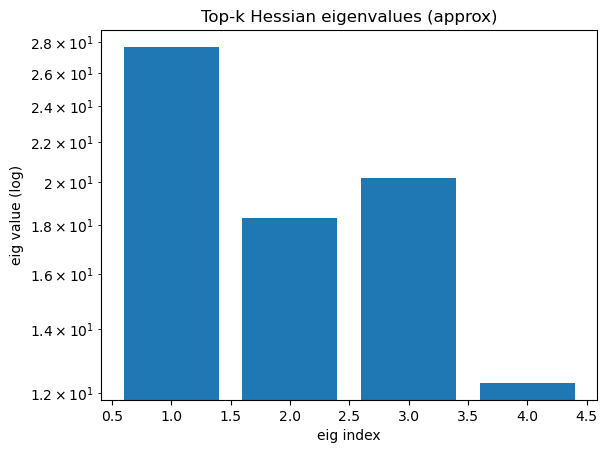

Trace estimate: 159.4382; topk sum: 78.4781; dim=50890
logV: 146692.41106265236 logV_per_dim: 2.8825390265799244


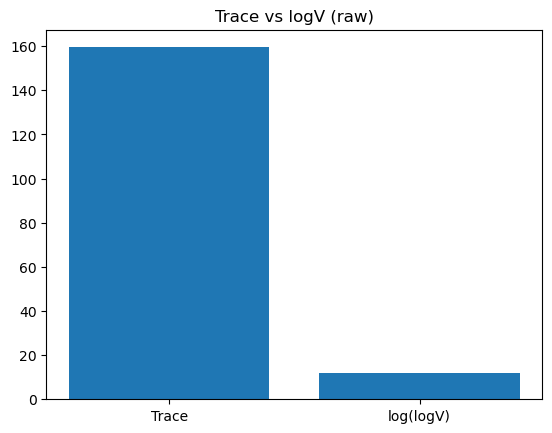

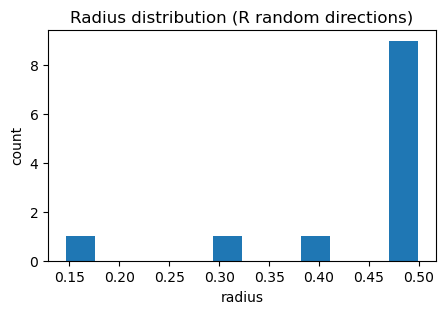

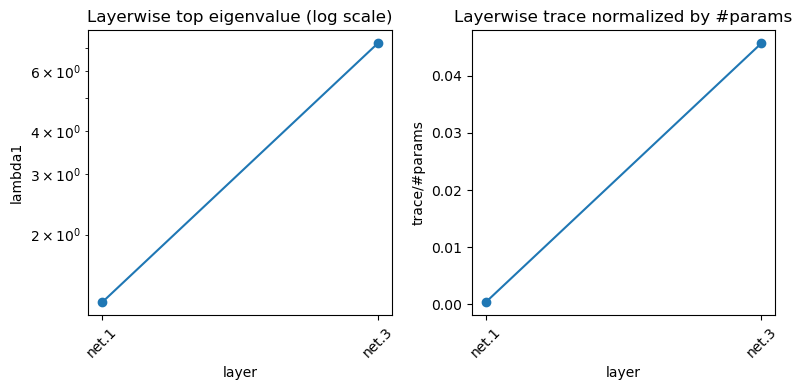

In [224]:
def quick_run_smoke(device='cpu'):
    seed_everything(0)
    train_loader, test_loader = load_mnist(batch_size=256, subset_train=2000, subset_test=1000)
    model = SmallMLP(hidden=64)
    model, history = train_model(model, train_loader, test_loader, epochs=20, device=device, lr=1e-3, seed=0, verbose=True)
    acc, loss = eval_stats(model, test_loader, device=device)
    print('Final acc, loss:', acc, loss)
    
    
    can = canonicalize_model(model)
    trace = hutchinson_trace_estimate(can, train_loader, num_samples=10, device=device)
    print('Trace est:', trace)
    eigvals, eigvecs = topk_eigvals_power_iteration(can, train_loader, k=4, iters=10, device=device)
    print('Top eigvals:', eigvals)
    dim = sum(p.numel() for p in can.parameters())
    lambda_tail = max(1e-6, trace / dim)
    logV = compute_log_volume_proxy(eigvals, dim, m_top=min(4, len(eigvals)), lambda_tail=lambda_tail)
    print('logV proxy:', logV)
    radii = random_direction_radius_scan(can, train_loader, device=device, R=12, delta_loss=0.01, max_r=0.5)
    print('median radius:', np.median(radii))
    
    
    # collect small ensemble
    # collect small ensemble
    ensemble = []
    for s in range(5):
        m = SmallMLP(hidden=64)
        m, _ = train_model(m, train_loader, test_loader, epochs=29, device=device, lr=1e-3, seed=s)
        
        # --- FIX START ---
        # Canonicalize (align) the model before flattening
        m_canon = canonicalize_model(m)
        ensemble.append(flat_params(m_canon))
        # --- FIX END ---
        
    mat = pairwise_distance_matrix(ensemble)
    plot_heatmap(mat, title='Euclidean distances (Canonicalized)')

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['test_loss'], label='test_loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss curves')
    plt.subplot(1,2,2)
    plt.plot(history['test_acc']); plt.xlabel('epoch'); plt.ylabel('test_acc'); plt.title('Test accuracy')
    plt.show()
    
    # 2) top-k eigvals barplot (log scale)
    plt.figure()
    k = len(eigvals)
    plt.bar(range(1,k+1), eigvals)
    plt.yscale('log')
    plt.xlabel('eig index'); plt.ylabel('eig value (log)')
    plt.title('Top-k Hessian eigenvalues (approx)')
    plt.show()
    
    # 3) trace & logV (show logV per-dim and raw)
    dim = sum(p.numel() for p in model.parameters())
    print(f"Trace estimate: {trace:.4f}; topk sum: {np.sum(eigvals):.4f}; dim={dim}")
    logV_per_dim = logV / dim
    print("logV:", logV, "logV_per_dim:", logV_per_dim)
    plt.figure()
    plt.bar([0,1], [trace, np.log(max(logV,1e-12))])
    plt.xticks([0,1], ['Trace', 'log(logV)'])
    plt.title('Trace vs logV (raw)')
    plt.show()
    
    # 4) radii histogram
    plt.figure(figsize=(5,3))
    plt.hist(radii, bins=12)
    plt.title('Radius distribution (R random directions)')
    plt.xlabel('radius'); plt.ylabel('count')
    plt.show()
    
    # 5) pairwise heatmap (if ensemble exists)
    if 'ensemble' in globals():
        flat_list = [safe_to_np(x) for x in ensemble]
        mat = pairwise_distance_matrix([torch.tensor(v) for v in flat_list])
        plot_heatmap(mat, title='Pairwise Euclidean distances of canonicalized minima')


    # Assume you ran:
    per_layer = topk_eigvals_per_layer(model, train_loader, k=4, iters=80, batches_for_loss=20)
    # Then plot:
    
    layers = [p['layer'] for p in per_layer]
    top1 = [p['eigvals'][0] for p in per_layer]
    trace = [p['trace'] for p in per_layer]
    num_params = [p['num_params'] for p in per_layer]
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(range(len(layers)), top1, marker='o')
    plt.yscale('log')
    plt.xticks(range(len(layers)), layers, rotation=45)
    plt.title('Layerwise top eigenvalue (log scale)'); plt.xlabel('layer'); plt.ylabel('lambda1')
    
    plt.subplot(1,2,2)
    plt.plot(range(len(layers)), np.array(trace)/np.array(num_params), marker='o')
    plt.xticks(range(len(layers)), layers, rotation=45)
    plt.title('Layerwise trace normalized by #params'); plt.xlabel('layer'); plt.ylabel('trace/#params')
    plt.tight_layout()
    plt.show()
    
# Run quick smoke test when executed directly
if __name__ == '__main__':
    quick_run_smoke(device='cpu')